fetching MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

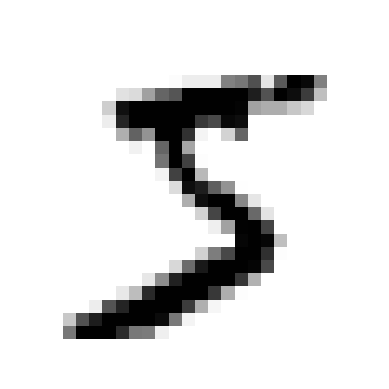

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

firstDigit = X.values[0]
firstDigitImage = firstDigit.reshape(28, 28)

plt.imshow(firstDigitImage, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

In [7]:
import numpy as np
y = y.astype(np.uint8)

In [8]:
int(y[0])

5

so far we checked the dataset a little

let's create a test set before doing further inspections on the data,
MNIST dataset is already split into a training set and test set:
first 60,000 image = training set
last 10,000 image = test set

In [9]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

let's create a Binary Classifier for now to keep it simple
with 5-detector will be an example of binary classifier, able to distinguish between two classes

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

now we need to pick a classifier
SGDClassifier has the advantage of being capable of handling very large datasets efficiently

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) 
# In machine learning, random_state=42 is commonly used as a convention to ensure reproducible results. 
# When you set a random seed, 
# you get the same "random" numbers each run, making your results consistent and debuggable.
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


now to use it to detect images of the number 5

In [ ]:
sgd_clf.predict([firstDigit])

Measuring Accuracy with Cross-Validation

Cross validation splits your data into multiple folds (typically 5 or 10), then:

Training: Uses k-1 folds to train the model
Testing: Tests on the remaining fold
Repeats: Does this k times, using each fold as test set once
Averages: Takes mean accuracy across all folds

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

A 5-digit classifier achieved 93%+ accuracy, which seems great. But a "dummy" classifier that always predicts "not-5" gets 90%+ accuracy simply because only ~10% of images are actually 5s.


With imbalanced datasets (where one class dominates), accuracy is misleading. A model can score high by just always guessing the majority class, without actually learning anything useful.

Confusion Matrix is better way ofc to measure performance of classifier
it's TP, TN, FP, FN system

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 53,892 = True Negatives (non-5, predicted as non-5)
- 687 = False Positives (non-5, predicted as 5)
- 1891 = False Negatives (5, predicted as non-5)
- 3530 = True Positives (5, predicted as 5)

Perfect classifier would have only TPs and TNs

In [16]:
y_train_perfect_predictions = y_train_5 # pretending we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Reminder:

- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)

In [17]:
from sklearn.metrics import precision_score, recall_score

In [18]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

- Precision: among all 5s, how many is correct?
- Recall: among all 5s, how many did model catch?

When model claims an image is a 5 it is only 83.7% correct,
and
it only detects 65.1% of 5s

F_1 - Score: precision and recall in a single metric:

F_1 = 2 x (P x R) / (P + R)

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

F_1 score is maximized when precision and recall are both high AND balanced. A classifier with 90% precision and 10% recall gets a much lower F_1 score than one with 70% precision and 70% recall, even though the first has higher precision.
So F_1 penalizes extreme imbalances between precision and recall.

Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
predict() method, you can call its decision_function() method, which returns a
score for each instance, and then use any threshold you want to make predictions
based on those scores

In [ ]:
y_scores = sgd_clf.decision_function([firstDigit])
y_scores

In [22]:
threshold = 0
y_firstDigit_pred = (y_scores > threshold)
y_firstDigit_pred

array([ True])

In [23]:
threshold = 8000
y_firstDigit_pred = (y_scores > threshold)
y_firstDigit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually repre‐
sents a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 8,000

How to decide which threshold to use?
use the cross_val_predict()
function to get the scores of all instances in the training set, but this time specify that
you want to return decision scores instead of predictions

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

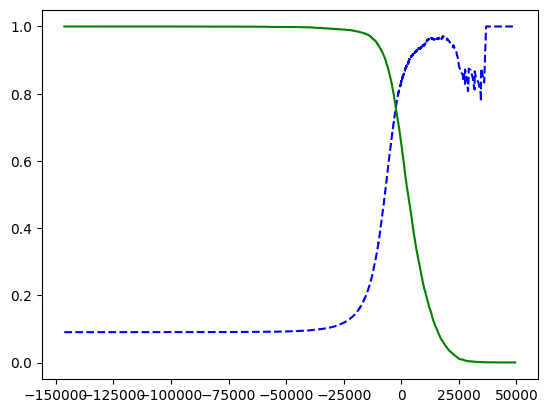

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

suppose we decide for 90%
and look up to threshold for it:

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
int(threshold_90_precision)

3370

In [28]:
# Only predict '5' if the confidence score is ≥ 3370, otherwise predict 'not-5'."
y_train_pred_90 = (y_scores >= threshold_90_precision) 

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

there we go we got ourselves a 90% precision!

now let's look at ROC curve where we plot sensitivity (exact same as recall) vs specifity (not same as precision but both for FPs)
- sensitivity = true positive rate, TP / (TP + FN)
- specifity = false positive rate, TN / (TN + FP)

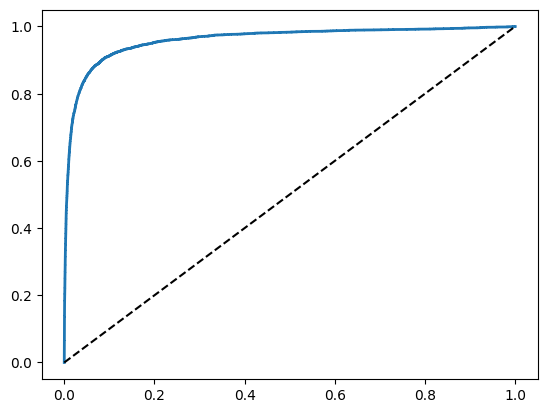

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

plot_roc_curve(fpr, tpr)
plt.show()

dotted line represents the curve of a purely random classifier; a good classifier stays far away from that line as possible

remember for a good model ROC AUC equal to 1, for a random model it's equal to 0.5

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

You now know how to train binary classifiers, choose the appropriate metric for your
task, evaluate your classifiers using cross-validation, select the precision/recall trade-
off that fits your needs, and use ROC curves and ROC AUC scores to compare vari‐
ous models. 

Binary vs Multiclass Classification:

Binary: 2 classes, Multiclass: 3+ classes
Some algorithms handle multiclass naturally (SGD, Random Forest, Naive Bayes)
Others are binary-only (Logistic Regression, SVM) but can use strategies below

Two Strategies for Multiclass with Binary Classifiers:
- One-vs-Rest (OvR):

Train N classifiers for N classes
Each asks "Is this my class or not?"
Pick class with highest confidence score

- One-vs-One (OvO):

Train N×(N-1)/2 classifiers for all class pairs
Each compares two specific classes
Pick class that wins most comparisons
Better for algorithms that scale poorly with dataset size

ELI5 Version:
- OvR: Like having 10 different detectors at airport security - one looks for guns, one for knives, etc. Each screams "FOUND IT!" when they see their thing. Loudest screamer wins.
- OvO: Like a tournament bracket. Every class fights every other class one-on-one (0 vs 1, 0 vs 2, 1 vs 2...). Whichever class wins the most fights is your answer.

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([firstDigit])

In [ ]:
firstDigit_score = svm_clf.decision_function([firstDigit])
firstDigit_score

In [35]:
np.argmax(firstDigit_score)

np.int64(5)

The highest score is indeed the one corresponding to class 5

In [36]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Let's try to force Scikit-learn to use OvO or OvR

In [37]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

,estimator,SVC()
,n_jobs,None
,verbose,0
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001


In [ ]:
ovr_clf.predict([firstDigit])

In [39]:
len(ovr_clf.estimators_)

10

training SGDClf or RandomForestClf is as easy

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([firstDigit])

now it doesnt have to run OvR or OvO cuz SGD can classify instances into multiple classes

In [ ]:
sgd_clf.decision_function([firstDigit])

You can see that the classifier is fairly confident about its prediction: almost all scores
are largely negative

In [42]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

~87% is not bad score, we can also increase it buy scaling up the inputs

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

there it is, it scaled up to ~89%

now let's analyze the errors

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

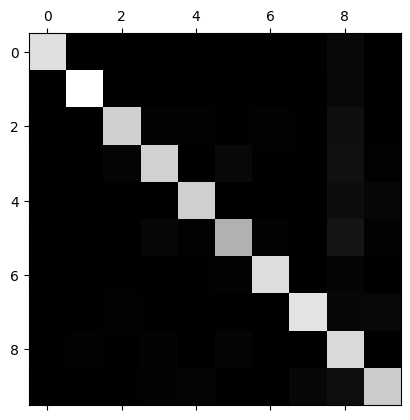

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

this confusion matrix looks good, since most images are on the main diagonal, which means that they were classified correctly

let's try to see where model struggles most by plotting on the error

Normalize by class size:
- Think about why this matters. If you have 1000 images of digit "1" but only 100 images of digit "0", then naturally you'll see more raw errors for digit "1" just because there are more samples. By dividing each row by its total count, you're converting absolute error counts into error rates. Now each cell shows "what percentage of actual class X was misclassified as class Y" rather than raw numbers.

In [46]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

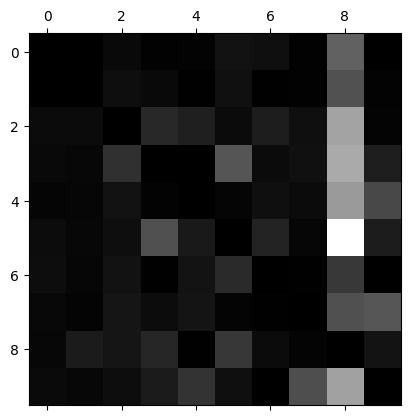

In [47]:
np.fill_diagonal(norm_conf_mx, 0) # Fill the diagonal with zeros to keep only the errors, and plot the result
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


it seems that model struggled classifying 8s

Multilabel Classification
- System that can assign multiple classes to a single instance, unlike traditional single-class prediction.
- Example: Face recognition identifying multiple people in one photo
    - Input: Photo with Alice and Charlie
    - Output: [1, 0, 1] = "Alice yes, Bob no, Charlie yes"

- Key difference: Each class gets its own binary decision (yes/no) rather than choosing one class from many options.

In [48]:
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] # numpy.c_[] concatenates arrays column-wise (horizontally)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [ ]:
knn_clf.predict([firstDigit]) # digit is 5 so it should be [False, True]

There are many ways to evaluate a multilabel classifier, and selecting the right metric
really depends on your project. One approach is to measure the F1 score for each
individual label, then simply compute the average score

In [50]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

this assumes that all labels are equally important, however, this may not be the case everytime
-> we can change it by setting average="weighted"

- SIDE NOTE:
    - ELI5: Cross-validation is like testing a student fairly
        - Bad way (cheating):

            - Teacher shows student 10 math problems
            - Student memorizes answers
            - Teacher tests student on same 10 problems
            - Student gets 100% (but didn't really learn)

        - Good way (cross-validation):

            - Teacher has 10 problems, splits into 3 groups
            - Round 1: Teach with groups 1+2, test on group 3
            - Round 2: Teach with groups 1+3, test on group 2
            - Round 3: Teach with groups 2+3, test on group 1

    - cross_val_predict(): Collects all the test answers from rounds 1-3
    - cross_val_score(): Collects the grades from each round (like 80%, 85%, 90%)
    - This way you know if the student actually learned, not just memorized.

Multioutput-Multiclass Classification:
- Each instance gets multiple labels, and each label can have multiple possible values (not just binary).
- Example: Image denoising

    - Input: Noisy digit image
    - Output: Clean image (array of pixel intensities)
    - Each pixel = one label with values 0-255

- Key difference from multilabel: Labels aren't just yes/no - they can be any value from a set of possibilities.

To illustrate this, let’s build a system that removes noise from images. It will take as
input a noisy digit image, and it will (hopefully) output a clean digit image, repre‐
sented as an array of pixel intensities, just like the MNIST images. Notice that the
classifier’s output is multilabel (one label per pixel) and each label can have multiple
values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput
classification system.

In [52]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

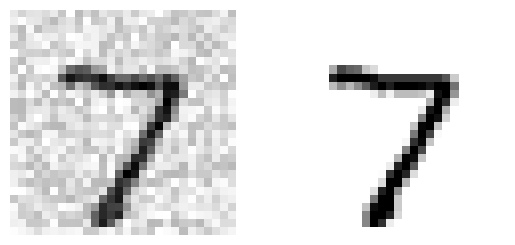

In [57]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

plt.subplot(121); plot_digit(X_test_mod.values[0])
plt.subplot(122); plot_digit(y_test_mod.values[0])
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[0]])
plot_digit(clean_digit)